In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchsummary import summary
from torchvision import models
from tqdm import tqdm

from mlfocus import util
from mlfocus.loader import MIPData, MyFFTData, get_loaders
from mlfocus.model import ResnetModel
from mlfocus.train import train_step, validate

try:
    wandb
except NameError:
    import wandb
        
    os.environ['WANDB_NOTEBOOK_NAME'] = 'fft_train.ipynb'
    wandb.init(project="fft-mlfocus")
    %load_ext autoreload
    %autoreload 2
    

wandb: Currently logged in as: tlambert03. Use `wandb login --relogin` to force relogin


loading fft: 100%|██████████| 4434/4434 [00:00<00:00, 5169.60it/s]


data shape (2, 32, 16) float32
label shape torch.Size([1])
dataset length 4434


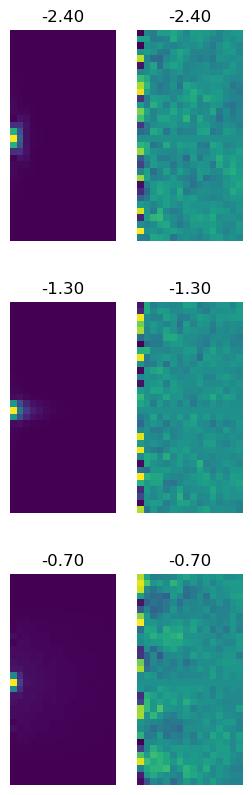

In [8]:
full_dset = MyFFTData("../mlfocus_data/")
util.preview_data(full_dset, n=3)

In [3]:
model = ResnetModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
batch_size = 1024
test_split = 0.1
learning_rate = 2e-3
epochs = 300

train_dataset = MyFFTData("../mlfocus_data/", exclude=["beads"])
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
# mt_data = MyFFTData("../mlfocus_data/", include=["mt002"])
# mt_loader = DataLoader(mt_data, batch_size=batch_size, shuffle=True)
bead3_data = MyFFTData("../mlfocus_data/", include=["beads"])
bead3_loader = DataLoader(bead3_data, batch_size=batch_size, shuffle=True)

all_loader = DataLoader(full_dset, batch_size=batch_size, shuffle=True)

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

wandb.config = {
    "learning_rate": 2e-3,
    "epochs": epochs,
    "batch_size": batch_size,
    "test_split": test_split,
}
wandb.watch(model)


[]

In [5]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for e in range(epochs):
    train_step(
        train_loader,
        model=model,
        optimizer=optimizer,
        loss=criterion,
        epoch_idx=e,
        device=device,
    )
    tot_val = validate(model, all_loader, criterion)
    # mt_val = validate(model, mt_loader, criterion)
    bead_val = validate(model, bead3_loader, criterion)
    wandb.log({"tot_val_loss": tot_val, "bead_val": bead_val, "epoch": e})
    
    # print("\nValidate: Average loss: {:.4f}\n".format(val_loss))
torch.save(model, 'models/fft_model.pt')

train:   0%|          | 0/3 [00:00<?, ?it/s]


KeyboardInterrupt: 

<AxesSubplot:xlabel='gt', ylabel='pred'>

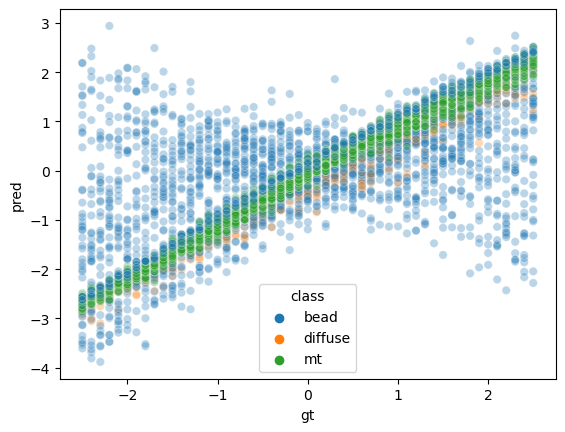

In [6]:
import seaborn as sns

df = util.characterize(model, full_dset, device=device, criterion=criterion)
sns.scatterplot(data=df, x="gt", y="pred", hue="class", alpha=0.3)

In [ ]:
model